In [2]:
image_dir = 'Users/ayeshamendoza/repos/fashion-recommender/data/images/zara'
output_dir = 'Users/ayeshamendoza/repos/fashion-recommender/data/output'

Vision-Language Annotation (BLIP)
Generate image captions using BLIP  
   - Model: `Salesforce/blip-image-captioning-base`  
   - Input: `zara/` images  
   - Output: `zara_captions.csv` with columns:  
     - `image`: filename  
     - `caption`: generated text

#### Uncomment to process and rename images

In [ ]:
# from transformers import BlipProcessor, BlipForConditionalGeneration
# from PIL import Image
# from pathlib import Path
# import pandas as pd
# import os

# # Load BLIP
# processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
# model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# image_dir = Path('drive/MyDrive/2025/graph-fashion-recsys/data/images/zara')
# output_dir = 'drive/MyDrive/2025/graph-fashion-recsys/data/output'
# image_paths = sorted(image_dir.glob("*.jpg"))

# captions = []

# for img_path in image_paths:
#     image = Image.open(img_path).convert("RGB")
#     inputs = processor(images=image, return_tensors="pt")
#     out = model.generate(**inputs)
#     caption = processor.decode(out[0], skip_special_tokens=True)
#     captions.append({"image": img_path.name, "caption": caption})
#     print(f"🖼️ {img_path.name} → {caption}")

# # Save to CSV
# df = pd.DataFrame(captions)
# df.to_csv(os.path.join(output_dir,"zara_blip_captions.csv"), index=False)


✅ Next Steps After This (Stacked Up)
Task	Outcome
🔎 Extract keywords from caption → keywords column	Tag-style supervision
💾 Run CLIP embeddings on zara/ images	Get clip_vectors.npy
🧱 Build full df with image, caption, keywords	Master dataframe for graph
🧵 Rebuild your item and attribute nodes	GCN v2 ready


In [ ]:
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

In [ ]:
import os
import torch
import clip
from PIL import Image
import pandas as pd

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Set paths
output_csv = os.path.join(output_dir, 'mvp_clip_image_embeddings.csv')

# ✅ Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process image files
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

embeddings = []
filenames = []

for img_name in image_files:
    try:
        img_path = os.path.join(image_dir, img_name)
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        with torch.no_grad():
            embedding = model.encode_image(image)
            embedding = embedding / embedding.norm(dim=-1, keepdim=True)

        embeddings.append(embedding.squeeze(0).cpu().numpy())
        filenames.append(img_name)

    except Exception as e:
        print(f"Error processing {img_name}: {e}")

# Save to CSV
df = pd.DataFrame(embeddings)
df.insert(0, "filename", filenames)
df.to_csv(output_csv, index=False)

print(f"✅ Done! Saved embeddings for {len(embeddings)} images to {output_csv}")

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.offsetbox as offsetbox
import umap

# === Load your embeddings and image paths ===
# Example: You have a CSV with paths and 512-dim CLIP embeddings


df_clip = pd.read_csv(output_csv)  # columns: image_path, e0, e1, ..., e511
image_paths = df_clip["filename"].tolist()
image_paths = [os.path.join(image_dir, path) for path in image_paths]
embeddings = df_clip.drop(columns=["filename"]).values

# === Reduce dimensionality to 2D using UMAP ===
num_neighbors = 5
min_dist = 0.1
reducer = umap.UMAP(n_neighbors=num_neighbors, min_dist=min_dist, metric='cosine')
embedding_2d = reducer.fit_transform(embeddings)


In [ ]:
def plot_with_thumbnails(embedding_2d, image_paths, zoom=0.5):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title("CLIP Embedding Space – 2D Visualization", fontsize=14)
    ax.set_xticks([]), ax.set_yticks([])

    for xy, path in zip(embedding_2d, image_paths):
        try:
            img = Image.open(path).convert("RGB")
            img.thumbnail((80, 80))
            imagebox = OffsetImage(img, zoom=zoom)
            ab = AnnotationBbox(imagebox, xy, frameon=False)
            ax.add_artist(ab)
        except Exception as e:
            print(f"Failed to load image: {path}, error: {e}")
            continue

    # Set limits to avoid tight zoom
    ax.set_xlim(embedding_2d[:,0].min() - 1, embedding_2d[:,0].max() + 1)
    ax.set_ylim(embedding_2d[:,1].min() - 1, embedding_2d[:,1].max() + 1)
    plt.tight_layout()
    plt.show()

# === Run it ===
plot_with_thumbnails(embedding_2d, image_paths)

In [ ]:
df_clip = pd.read_csv(os.path.join(output_dir, "mvp_clip_image_embeddings.csv"))
df_blip = pd.read_csv(os.path.join(output_dir, "mvp_zara_blip_captions_updated.csv"))
df_blip.head()

In [ ]:
# Extract keywords from captions

# !pip install spacy
# !python -m spacy download en_core_web_sm

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_keywords(caption):
    doc = nlp(caption.lower())
    return [token.lemma_ for token in doc if token.pos_ in ["NOUN", "ADJ"] and len(token.text) > 2]


In [ ]:
df_blip["keywords"] = df_blip["caption"].apply(extract_keywords)
df_blip.to_csv(os.path.join(output_dir,"mvp_captions_with_keywords.csv"), index=False)
print(df_blip[["image", "keywords"]])


In [ ]:
all_keywords = set(kw for kws in df_blip["keywords"] for kw in kws)
attribute_to_idx = {kw: idx + len(df_blip) for idx, kw in enumerate(sorted(all_keywords))}

item_to_idx = {img: i for i, img in enumerate(df_blip["image"])}  # item node indices

item_attr_edges = []

for i, row in df_blip.iterrows():
    item_idx = item_to_idx[row["image"]]
    for keyword in row["keywords"]:
        attr_idx = attribute_to_idx[keyword]
        item_attr_edges.append((item_idx, attr_idx))  # directed: item → attribute

📦 5. Build edge_index Tensor

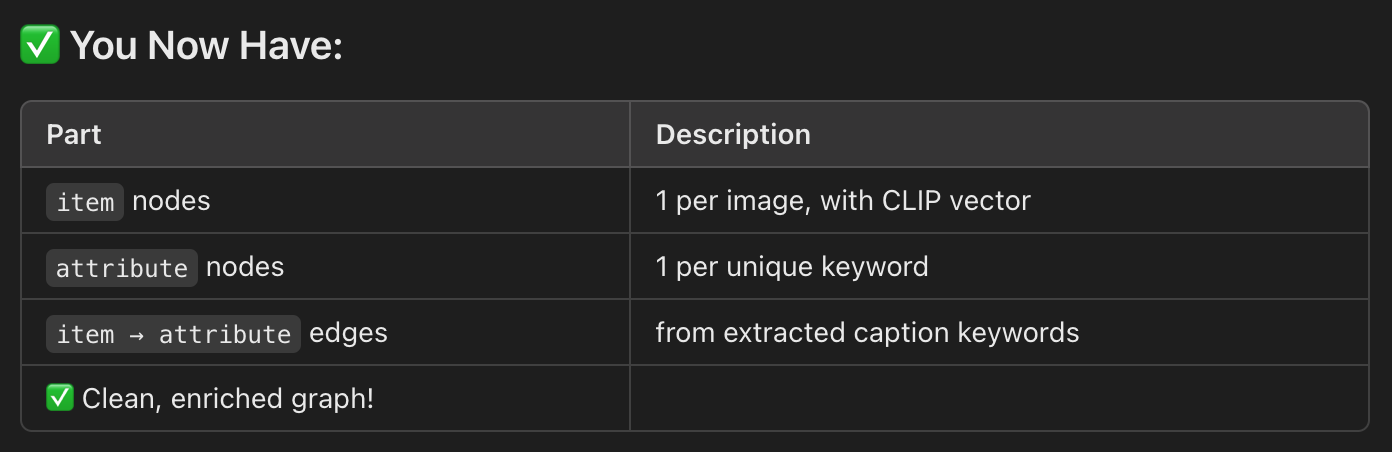

In [ ]:
edge_index = torch.tensor(item_attr_edges, dtype=torch.long).T  # shape [2, num_edges]
print(edge_index.shape)  # [2, N]
torch.save(edge_index, os.path.join(output_dir,"mvp_item_attr_edge_idx.pt"))

✅ STEP 2: Map Image Filenames to Node IDs

🔍 What?
Your captions file (image_captions_blip.csv) has a column with image filenames. Each image = an item node with an ID from 0 to 10.

✅ Why?
We need to make sure the order of CLIP vectors matches the order of item nodes in the graph.

In [ ]:
df_clip.head()

*✅* Step 2a: Reorder CLIP Vectors to Match BLIP Captions

In [ ]:
# Set "filename" as index
df_clip = df_clip.set_index("filename")
df_clip.head()

In [ ]:
import numpy as np

clip_map = {img: row for img, row in zip(df_clip.index, df_clip.values)}
ordered_vectors = np.array([clip_map[img] for img in df_blip["image"]])
item_vectors = ordered_vectors

In [ ]:
item_vectors

✅ STEP 3: Create Dummy Vectors for Attribute Nodes
🔍 What?
You now have attribute nodes — one for each keyword/tag extracted from BLIP.

✅ Why?
These nodes need some vector representation, even if they're not real embeddings yet. We'll use simple dummy vectors for now (e.g., zeros).

Later you could:

Replace with one-hot

Use text embeddings from CLIP or GloVe for fun!

In [ ]:
num_attrs = len(attribute_to_idx)  # from yesterday's tag mapping
attr_vectors = np.zeros((num_attrs, 512))  # 512 to match CLIP dim
num_attrs

✅ STEP 4: Stack Both into Final x Tensor
🔍 What?
Stack all your vectors:

First the item CLIP vectors

Then the dummy attribute vectors

✅ Why?
The final graph will treat these as one tensor, one row per

In [ ]:
x_np = np.vstack([item_vectors, attr_vectors])
x = torch.tensor(x_np, dtype=torch.float)
print(x.shape)  # should be (num_items + num_attrs, 512)


In [ ]:
# Blip captions data
# df.to_csv(os.path.join(output_dir,"image_captions_with_keywords.csv"), index=False)

# Mapping dictionaries
import pickle

with open(os.path.join(output_dir,"item_to_idx.pkl"), "wb") as f:
    pickle.dump(item_to_idx, f)

with open(os.path.join(output_dir,"attribute_to_idx.pkl"), "wb") as f:
    pickle.dump(attribute_to_idx, f)

# Item clip vectors
np.save(os.path.join(output_dir,"item_vectors_clip.npy"), item_vectors)

# Attribute Dummy vectors
np.save(os.path.join(output_dir,"attribute_vectors_dummy.npy"), attr_vectors)

torch.save(x, os.path.join(output_dir,"x_tensor_before_enrichment.pt"))

✅ Enrich Attribute Nodes with CLIP Text Embeddings
We’ll use the CLIP text encoder to convert each attribute keyword (like "floral", "vintage", "maxi") into a 512-d embedding, just like the image vectors.

This gives every attribute node its own rich style representation ✨

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()  # inference mode


In [ ]:
sorted_keywords = sorted(all_keywords)
num_items = item_vectors.shape[0]

attribute_to_idx = {kw: idx + num_items for idx, kw in enumerate(sorted_keywords)}
keywords = list(attribute_to_idx.keys())  # the actual words like "floral"
keywords[:3]

In [ ]:
# Run CLIP text embedding

text_inputs = processor(text=keywords, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)  # shape: (num_keywords, 512)
# text_features.shape → torch.Size([num_attributes, 512])


In [ ]:
torch.save(text_features, os.path.join(output_dir,"mvp_attr_vectors_clip_text.pt"))
attr_vectors = text_features.cpu().numpy()

In [ ]:
# Rebuild Final Node Feature Matrix

#item_vectors = np.load(os.path.join(output_dir,"item_vectors_clip.npy"))  # shape: (num_items, 512)
x_np = np.vstack([item_vectors, attr_vectors])  # full node feature matrix
x = torch.tensor(x_np, dtype=torch.float)
print(x.shape)  # (num_items + num_attributes, 512)
torch.save(x, os.path.join(output_dir,"mvp_enriched_vectors_clip_blip.pt"))

### >>> Restart here <<<

In [3]:
import numpy as np
import pandas as pd
import torch
import pickle
import os

# --- Node Feature Data ---
item_vectors = np.load(os.path.join(output_dir, "item_vectors_clip.npy")) # shape: (num_items, 512)
text_features = torch.load(os.path.join(output_dir, "mvp_attr_vectors_clip_text.pt"))
attr_vectors = text_features.cpu().numpy()         # shape: (num_attrs, 512)

# Stack to create node feature matrix
x_np = np.vstack([item_vectors, attr_vectors])
x = torch.tensor(x_np, dtype=torch.float)
print(f"x shape: {x.shape}")  # (num_nodes, 512)

# --- Node Index Mappings ---
with open(os.path.join(output_dir, "item_to_idx.pkl"), "rb") as f:
    item_to_idx = pickle.load(f)

with open(os.path.join(output_dir, "attribute_to_idx.pkl"), "rb") as f:
    attribute_to_idx = pickle.load(f)

# --- BLIP Captions + Keywords ---
df = pd.read_csv(os.path.join(output_dir, "mvp_captions_with_keywords.csv"))

# --- Item → Attribute Edges ---
# with open(os.path.join(output_dir, "item_attr_edge.pkl"), "rb") as f:
#     item_attr_edges = pickle.load(f)

# item_attr_edge_index = torch.tensor(item_attr_edges, dtype=torch.long).T

item_attr_edge_index = torch.load(os.path.join(output_dir, "mvp_item_attr_edge_idx.pt"))
print(f"Item → Attribute edge_index shape: {item_attr_edge_index.shape}")


x shape: torch.Size([143, 512])
Item → Attribute edge_index shape: torch.Size([2, 254])


✅ Generate Item ↔ Item Similarity Edges
We’ll use cosine similarity to connect visually similar items (based on CLIP embeddings).

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load item vectors
item_vectors = np.load(os.path.join(output_dir,"item_vectors_clip.npy"))  # shape: (num_items, 512)

# Compute cosine similarity between all item pairs
cos_sim = cosine_similarity(item_vectors)

# Optional: zero out self-similarity (diagonal)
np.fill_diagonal(cos_sim, 0)

# Pick top-k similar items per item (e.g. k=2)
k = 3
item_item_edges = []

num_items = item_vectors.shape[0]
for i in range(num_items):
    top_k = np.argsort(cos_sim[i])[-k:]  # indices of top-k similar items
    for j in top_k:
        item_item_edges.append((i, j))
        item_item_edges.append((j, i))  # Make it undirected

# Convert to PyG format
import torch
item_item_edge_index = torch.tensor(item_item_edges, dtype=torch.long).T
print(f"item_item_edge_index shape: {item_item_edge_index.shape}")


item_item_edge_index shape: torch.Size([2, 312])


In [5]:
# Combine item↔attribute and item↔item edges
full_edge_index = torch.cat([item_attr_edge_index, item_item_edge_index], dim=1)
print(f"full_edge_index shape: {full_edge_index.shape}")


full_edge_index shape: torch.Size([2, 566])


In [6]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.7 MB/s eta 0:00:00


In [7]:
from torch_geometric.data import Data

# x = your final node feature tensor
data = Data(x=x, edge_index=full_edge_index)

# Optional: add metadata
data.num_nodes = x.shape[0]
data.num_item_nodes = item_vectors.shape[0]
data.num_attr_nodes = attr_vectors.shape[0]
print(data)


Data(x=[143, 512], edge_index=[2, 566], num_nodes=143, num_item_nodes=52, num_attr_nodes=91)


In [ ]:
torch.save(data, os.path.join(output_dir,"mvp_fashion_graph_data.pt"))

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import matplotlib.pyplot as plt
import os

image_dir = 'drive/MyDrive/2025/graph-fashion-recsys/data/images/zara'

# Pick an image to analyze
# anchor_idx = 0
# anchor_idx = 5
anchor_idx = 51#43#40#37#31#25
anchor_img = df.iloc[anchor_idx]["image"]
anchor_vec = item_vectors[anchor_idx].reshape(1, -1)

# Compute similarity to all others
sims = cosine_similarity(anchor_vec, item_vectors)[0]

# Get top k similar (excluding itself)
top_k = sims.argsort()[-5:][::-1]  # top-3 incl. itself
top_k = [i for i in top_k if i != anchor_idx][:3]

print(f"\nAnchor image: {anchor_img}")
print(f"Top similar images and similarity scores:")

for i in top_k:
    print(f"- {df.iloc[i]['image']} → similarity = {sims[i]:.4f}")


Anchor image: zara_53.jpg
Top similar images and similarity scores:
- zara_07.jpg → similarity = 0.9197
- zara_28.jpg → similarity = 0.9172
- zara_31.jpg → similarity = 0.9084


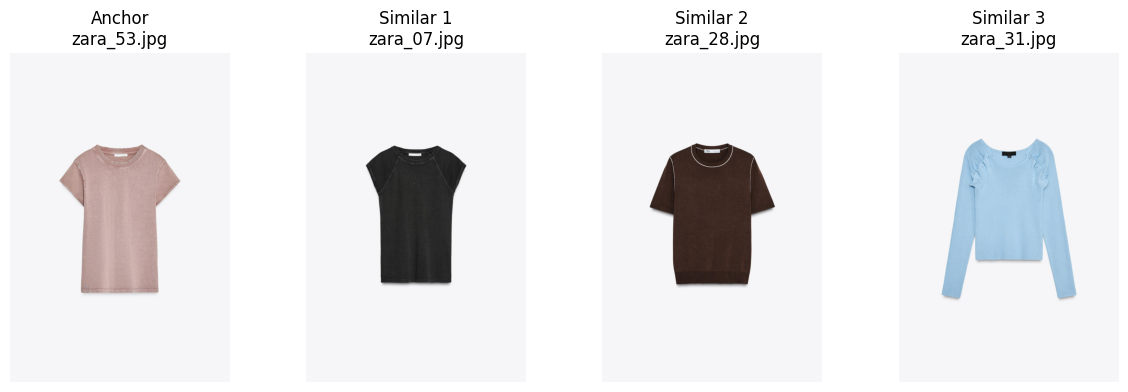

In [9]:
def show_images(indices, df, image_dir):
    fig, axs = plt.subplots(1, len(indices)+1, figsize=(12, 4))

    # Anchor image
    anchor_path = os.path.join(image_dir, df.iloc[anchor_idx]["image"])
    axs[0].imshow(Image.open(anchor_path))
    axs[0].set_title("Anchor\n" + df.iloc[anchor_idx]["image"])
    axs[0].axis("off")

    # Similar images
    for i, idx in enumerate(indices):
        img_path = os.path.join(image_dir, df.iloc[idx]["image"])
        axs[i+1].imshow(Image.open(img_path))
        axs[i+1].set_title(f"Similar {i+1}\n" + df.iloc[idx]["image"])
        axs[i+1].axis("off")

    plt.tight_layout()
    plt.show()

# Show anchor + 2 most similar
show_images(top_k, df, image_dir)


In [ ]:
# output_dir

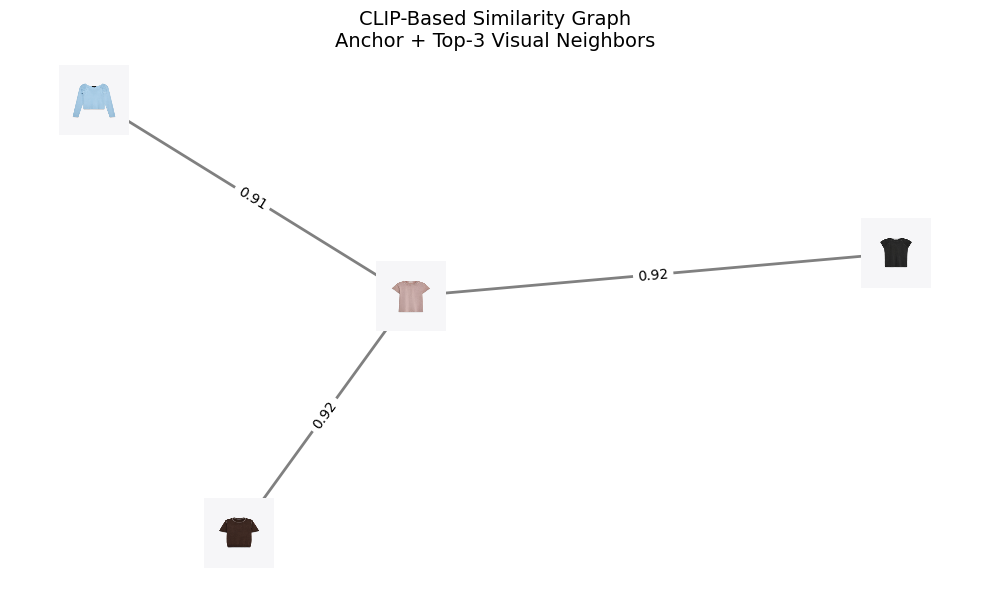

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
import os

# === Data Setup ===
# anchor_idx = 5
anchor_img = df.iloc[anchor_idx]["image"]
similar_idxs = top_k  # from previous cosine sim step
similar_imgs = [df.iloc[i]["image"] for i in similar_idxs]
sim_scores = [sims[i] for i in similar_idxs]

# === Create Graph ===
G = nx.Graph()
G.add_node(anchor_img)
for img in similar_imgs:
    G.add_node(img)
for i, img in enumerate(similar_imgs):
    G.add_edge(anchor_img, img, weight=sim_scores[i])

# === Plot Setup ===
pos = nx.spring_layout(G, seed=42)
fig, ax = plt.subplots(figsize=(10, 6))
nx.draw_networkx_edges(G, pos, ax=ax, width=2, edge_color="gray")

# === Draw Image Thumbnails ===
def draw_image_node(ax, position, image_path, zoom=0.1):
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox

    img = Image.open(image_path).convert("RGB")
    img = img.resize((200, 200))  # Resize in pixels

    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, position, frameon=False)
    ax.add_artist(ab)

# Map node name to image path
image_dir = 'drive/MyDrive/2025/graph-fashion-recsys/data/images/zara'
node_to_path = {
    anchor_img: os.path.join(image_dir, anchor_img),
    **{img: os.path.join(image_dir, img) for img in similar_imgs}
}

# Draw thumbnails at the correct positions
for node in G.nodes:
    draw_image_node(ax, pos[node], node_to_path[node], zoom=0.25)  # Adjust zoom as needed


# === Draw Edge Labels (cosine sim) ===
edge_labels = {
    (anchor_img, img): f"{G[anchor_img][img]['weight']:.2f}" for img in similar_imgs
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=10)

# === Final Touches ===
plt.title("CLIP-Based Similarity Graph\nAnchor + Top-3 Visual Neighbors", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(output_dir,f"clip_similarity_graph{anchor_idx}.png"), dpi=300, bbox_inches="tight")

plt.show()

### Restart @ GNN training

In [ ]:
# !pip install torch_geometric

In [6]:
image_dir

'Users/ayeshamendoza/repos/fashion-recommender/data/images/zara'

In [5]:
import os
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np


In [7]:
output_dir = '/Users/ayeshamendoza/repos/fashion-recommender/data/output'
image_dir = '/Users/ayeshamendoza/repos/fashion-recommender/data/images/zara'

In [8]:
graph_path = os.path.join(output_dir,"mvp_fashion_graph_data.pt")
data = torch.load(graph_path, weights_only=False)

# 📊 Inspect
print(data)
print(f"Node feature shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")


Data(x=[143, 512], edge_index=[2, 566], num_nodes=143, num_item_nodes=52, num_attr_nodes=91, node_type=[143])
Node feature shape: torch.Size([143, 512])
Edge index shape: torch.Size([2, 566])


In [9]:

num_item_nodes = data.num_item_nodes
num_attr_nodes = data.num_attr_nodes

# Create node type tensor
node_type = torch.tensor([0] * num_item_nodes + [1] * num_attr_nodes)

# Assign to your graph
data.node_type = node_type

print("Node type tensor shape:", data.node_type.shape)
print("Node types:", torch.unique(data.node_type, return_counts=True))
torch.save(data, graph_path)

Node type tensor shape: torch.Size([143])
Node types: (tensor([0, 1]), tensor([52, 91]))


✅ Build a Basic GNN (GCN or GraphSAGE)
We’ll start with GCNConv — it’s simple, effective, and great for learning structure.

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


Each row in node_embeddings is a 64-dimensional vector for a node — item or attribute — updated by aggregating information from its neighbors.

In [14]:
model = GCN(in_channels=512, hidden_channels=128, out_channels=64)

# Move to device if using CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
model = model.to(device)

# Forward pass
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index)

print("New node embeddings shape:", node_embeddings.shape)


New node embeddings shape: torch.Size([143, 64])


In [15]:
torch.save(node_embeddings, os.path.join(output_dir,"mvp_node_embeddings_gcn.pt"))

In [16]:
df_embed = pd.DataFrame(node_embeddings.cpu().numpy())
# df_embed.to_csv("outputs/node_embeddings_gcn.csv", index=False)
df_embed.head()

0         1         2         3         4         5         6   \
0  0.030258  0.038545 -0.008652 -0.000858  0.010853  0.015511  0.003749   
1  0.040811  0.056634 -0.004559  0.022062  0.046127  0.035689  0.006952   
2  0.051471  0.068725 -0.001168  0.021903  0.040339  0.037927  0.015177   
3  0.038604  0.043051 -0.006074  0.016088  0.023303  0.021710  0.006626   
4  0.034905  0.070469 -0.005961  0.006755  0.005316  0.033587 -0.014318   

         7         8         9   ...        54        55        56        57  \
0 -0.031179 -0.007834 -0.029464  ...  0.030884  0.009723  0.017901  0.000526   
1 -0.034627 -0.001256 -0.016231  ...  0.056508  0.019734  0.039297  0.025957   
2 -0.044219 -0.006582 -0.028161  ...  0.070448  0.026208  0.041251  0.027549   
3 -0.029887  0.001408 -0.023847  ...  0.047159  0.012678  0.027573  0.020626   
4 -0.043049 -0.027350 -0.025036  ...  0.053721  0.036385  0.008992  0.020026   

         58        59        60        61        62        63  
0  0.015438 -0.012529 -0.090928 -0.033343 -0.043074  0.007826  
1  0.032272 -0.028492 -0.083530 -0.037948 -0.015668 -0.032131  
2  0.036022 -0.029881 -0.103105 -0.041648 -0.024852 -0.024830  
3  0.025532 -0.022543 -0.060240 -0.025838 -0.013514 -0.017454  
4  0.039750 -0.014304 -0.105016 -0.060494 -0.036324  0.003085  

[5 rows x 64 columns]

In [17]:
df_embed.shape

(143, 64)

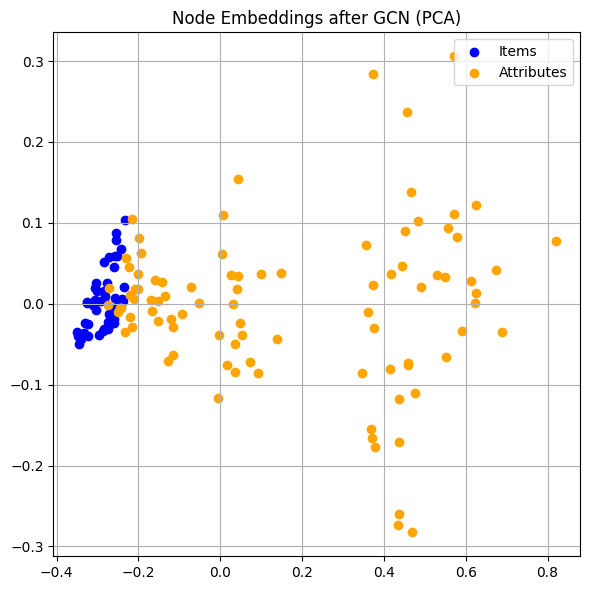

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(node_embeddings.cpu().numpy())

plt.figure(figsize=(6, 6))
plt.scatter(emb_2d[:num_item_nodes, 0], emb_2d[:num_item_nodes, 1], label="Items", c="blue")
plt.scatter(emb_2d[num_item_nodes:, 0], emb_2d[num_item_nodes:, 1], label="Attributes", c="orange")
plt.title("Node Embeddings after GCN (PCA)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import ast

df = pd.read_csv(os.path.join(output_dir, "mvp_captions_with_keywords.csv"))
# Only item nodes have labels


# Convert stringified lists to actual lists
df["keywords"] = df["keywords"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

item_keywords = df["keywords"]

mlb = MultiLabelBinarizer()
y_tags = mlb.fit_transform(item_keywords)

# Convert to tensor
y = torch.tensor(y_tags).float()

# Save tag names (optional, for reverse lookup)
tag_names = mlb.classes_

Split item nodes

In [20]:
from sklearn.model_selection import train_test_split

item_indices = torch.arange(num_item_nodes)
train_idx, test_idx = train_test_split(item_indices, test_size=0.2, random_state=42)

# Create boolean masks
train_mask = torch.zeros(num_item_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_item_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

In [21]:
import torch.nn as nn

class GCNTagPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return self.linear(x)


In [22]:
# edge_index = full_edge_index
edge_index = data.edge_index
type(edge_index)

torch.Tensor

In [23]:
model = GCNTagPredictor(in_channels=512, hidden_channels=256, out_channels=y.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
threshold = 0.3

for epoch in range(100):
    model.train()
    out = model(x, edge_index)  # (all node logits)
    item_logits = out[:num_item_nodes]  # only item nodes

    loss = criterion(item_logits[train_mask], y[train_mask].float())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % 10 == 0:
        with torch.no_grad():
            model.eval()
            test_logits = item_logits[test_mask]
            preds = (test_logits.sigmoid() > threshold).int()
            acc = (preds == y[test_mask]).float().mean().item()
            print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Test Match Acc: {acc:.2f}")



Epoch 0 | Loss: 0.6928 | Test Match Acc: 0.06
Epoch 10 | Loss: 0.5633 | Test Match Acc: 0.06
Epoch 20 | Loss: 0.2298 | Test Match Acc: 0.94
Epoch 30 | Loss: 0.2142 | Test Match Acc: 0.94
Epoch 40 | Loss: 0.1881 | Test Match Acc: 0.93
Epoch 50 | Loss: 0.1856 | Test Match Acc: 0.94
Epoch 60 | Loss: 0.1820 | Test Match Acc: 0.94
Epoch 70 | Loss: 0.1813 | Test Match Acc: 0.94
Epoch 80 | Loss: 0.1802 | Test Match Acc: 0.94
Epoch 90 | Loss: 0.1788 | Test Match Acc: 0.94


In [ ]:
torch.save(model.state_dict(), os.path.join(output_dir, "mvp_gcn_tag_predictor.pt"))
torch.save(out, os.path.join(output_dir, "node_logits.pt"))  # if you want to keep full node embeddings



*Run predictions on Test nodes*

In [ ]:
model.eval()
with torch.no_grad():
    out = model(x, edge_index)  # Full graph forward
    item_logits = out[:num_item_nodes]  # Only item nodes
    preds_binary = (item_logits.sigmoid() > threshold).int()


*Compare Predicted Tags vs. True Tags*


In [ ]:
from sklearn.metrics import classification_report

# Decode predictions (list of lists of strings)
predicted_tags = mlb.inverse_transform(preds_binary[test_mask].numpy())
true_tags = mlb.inverse_transform(y[test_mask].numpy())


In [ ]:
for i, idx in enumerate(test_idx[:5]):
  print(i, idx)

In [ ]:
for i, idx in enumerate(test_idx[:5].numpy()):
    print(f"🖼️ {df.iloc[idx]['image']}")
    print(f"✅ True Tags: {true_tags[i]}")
    print(f"🤖 Predicted Tags: {predicted_tags[i]}")
    print()

In [ ]:
item_logits = model(x, edge_index)[:num_item_nodes]
probs = item_logits[test_mask].sigmoid()

print(probs[:5])  # Show first 5 test item predictions

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(
    y[test_mask], preds_binary[test_mask], average='macro'
)

print(f"📊 Tag Prediction (Macro Avg) — Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")


### Restart here for Graph-powered Recommender

✅ Step-by-Step:[link text](https://) Item → Item Recommender (Cosine Similarity)
🧠 What We’re Doing:
We’ll use:

Your trained model(x, edge_index)

Take embeddings for just item nodes

Compute cosine similarity

Recommend top-K most similar items per item

In [10]:
import os
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np

graph_path = os.path.join(output_dir,"mvp_fashion_graph_data.pt")
data = torch.load(graph_path, weights_only=False)

# 📊 Inspect
print(data)
print(f"Node feature shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")

num_item_nodes = data.num_item_nodes
num_attr_nodes = data.num_attr_nodes

Data(x=[143, 512], edge_index=[2, 566], num_nodes=143, num_item_nodes=52, num_attr_nodes=91, node_type=[143])
Node feature shape: torch.Size([143, 512])
Edge index shape: torch.Size([2, 566])


Extract Item Embeddings

In [25]:
model.eval()
with torch.no_grad():
    all_node_embeddings = model(x, edge_index)
    item_embeddings = all_node_embeddings[:num_item_nodes]  # Only item nodes


Compute cosine similarity Matrix

In [26]:
import torch.nn.functional as F

# Normalize to unit vectors
item_norm = F.normalize(item_embeddings, p=2, dim=1)

# Cosine similarity matrix (num_items x num_items)
# cos_sim_matrix = torch.matmul(item_norm, item_norm.T)
# Remove normalization
cos_sim_matrix = torch.matmul(item_embeddings, item_embeddings.T)



Get Top-K Similar Items

In [27]:
top_k = 5  # you can adjust this

similar_items = {}

for idx in range(num_item_nodes):
    sim_scores = cos_sim_matrix[idx]

    # Exclude self by setting its sim to -1
    sim_scores[idx] = -1.0

    # Top K most similar item indices
    topk_indices = torch.topk(sim_scores, top_k).indices.tolist()
    topk_scores = sim_scores[topk_indices].tolist()

    similar_items[df.iloc[idx]['image']] = [
        (df.iloc[i]['image'], score) for i, score in zip(topk_indices, topk_scores)
    ]


In [28]:
similar_items.keys()

dict_keys(['zara_01.jpg', 'zara_02.jpg', 'zara_03.jpg', 'zara_04.jpg', 'zara_05.jpg', 'zara_06.jpg', 'zara_07.jpg', 'zara_08.jpg', 'zara_09.jpg', 'zara_10.jpg', 'zara_11.jpg', 'zara_12.jpg', 'zara_13.jpg', 'zara_14.jpg', 'zara_15.jpg', 'zara_16.jpg', 'zara_17.jpg', 'zara_18.jpg', 'zara_19.jpg', 'zara_20.jpg', 'zara_21.jpg', 'zara_22.jpg', 'zara_23.jpg', 'zara_24.jpg', 'zara_25.jpg', 'zara_26.jpg', 'zara_27.jpg', 'zara_28.jpg', 'zara_29.jpg', 'zara_30.jpg', 'zara_31.jpg', 'zara_32.jpg', 'zara_33.jpg', 'zara_34.jpg', 'zara_35.jpg', 'zara_36.jpg', 'zara_37.jpg', 'zara_38.jpg', 'zara_39.jpg', 'zara_40.jpg', 'zara_41.jpg', 'zara_42.jpg', 'zara_43.jpg', 'zara_44.jpg', 'zara_45.jpg', 'zara_46.jpg', 'zara_47.jpg', 'zara_48.jpg', 'zara_49.jpg', 'zara_50.jpg', 'zara_51.jpg', 'zara_53.jpg'])

In [29]:
anchor = list(similar_items.keys())[0]
print(f"🔍 Anchor: {anchor}")
for sim_img, score in similar_items[anchor]:
    print(f"🧷 {sim_img} (Similarity: {score:.2f})")


🔍 Anchor: zara_01.jpg
🧷 zara_12.jpg (Similarity: 1335.52)
🧷 zara_28.jpg (Similarity: 1317.63)
🧷 zara_38.jpg (Similarity: 1282.15)
🧷 zara_08.jpg (Similarity: 1230.60)
🧷 zara_36.jpg (Similarity: 1220.94)


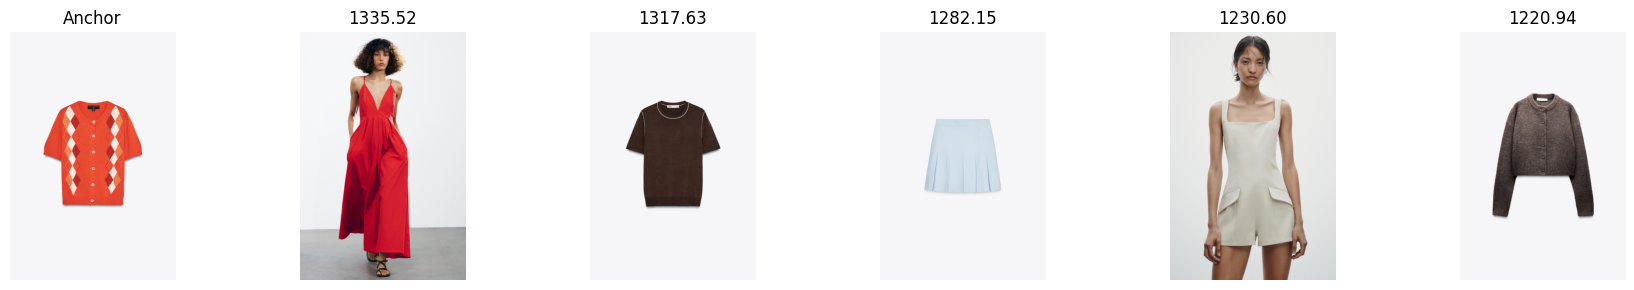

In [30]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path



def show_similar_items(anchor_img, top_k_list, image_dir):
    num_cols = len(top_k_list) + 1
    fig, axes = plt.subplots(1, num_cols, figsize=(3 * num_cols, 3))

    # Load and show anchor image
    anchor_path = os.path.join(image_dir, anchor_img)
    anchor_img = Image.open(anchor_path).convert("RGB")
    axes[0].imshow(anchor_img)
    axes[0].set_title("Anchor")
    axes[0].axis("off")

    # Show recommended images
    for i, (sim_img, score) in enumerate(top_k_list):
        img_path = os.path.join(image_dir, sim_img)
        img = Image.open(img_path).convert("RGB")
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"{score:.2f}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

# 🔍 Example: Visualize 1 item and its top-K
anchor = list(similar_items.keys())[0]
show_similar_items(anchor, similar_items[anchor], image_dir)


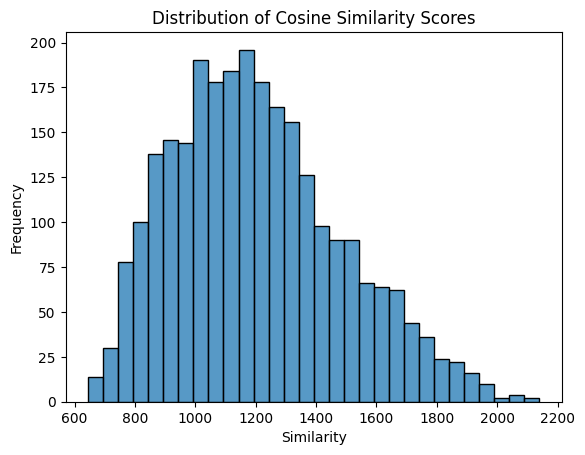

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude self-similarity
sim_scores = cos_sim_matrix[~torch.eye(num_item_nodes, dtype=bool)].flatten()

sns.histplot(sim_scores.numpy(), bins=30)
plt.title("Distribution of Cosine Similarity Scores")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.show()


### Using Hidden Embeddings to handle highly clustered embeddings

In [ ]:
# with torch.no_grad():
#     h1 = model.conv1(x, edge_index)
#     h1 = F.relu(h1)
#     h2 = model.conv2(h1, edge_index)
#     h2 = F.relu(h2)
#     item_embeddings = h2[:num_item_nodes]  # Use as similarity base


In [ ]:
# item_norm = F.normalize(item_embeddings, p=2, dim=1)
# cos_sim_matrix = torch.matmul(item_norm, item_norm.T)


In [ ]:
# sim_scores = cos_sim_matrix[~torch.eye(num_item_nodes, dtype=bool)].flatten()
# sns.histplot(sim_scores.numpy(), bins=30)


In [ ]:
# anchor = list(similar_items.keys())[0]
# print(f"Anchor Item: {anchor}")
# for sim_img, score in similar_items[anchor]:
#     print(f"  → {sim_img} (Similarity: {score:.2f})")


### option 2:  Euclidean Distance

In [32]:
# from torch.cdist import cdist

# Lower = more similar
euclidean_matrix = torch.cdist(item_embeddings, item_embeddings, p=2)

# For each item, get smallest distances (excluding self)
similar_items = {}

for idx in range(num_item_nodes):
    dists = euclidean_matrix[idx]
    dists[idx] = float("inf")  # exclude self

    topk_indices = torch.topk(-dists, k=top_k).indices.tolist()  # negative for lowest distances
    topk_scores = dists[topk_indices].tolist()

    similar_items[df.iloc[idx]['image']] = [
        (df.iloc[i]['image'], score) for i, score in zip(topk_indices, topk_scores)
    ]


In [34]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def show_similar_items_euclidean(anchor_img, top_k_list, image_dir):
    num_cols = len(top_k_list) + 1
    fig, axes = plt.subplots(1, num_cols, figsize=(3 * num_cols, 3))

    # Load and show anchor image
    anchor_path = os.path.join(image_dir, anchor_img)
    anchor_img_data = Image.open(anchor_path).convert("RGB")
    axes[0].imshow(anchor_img_data)
    axes[0].set_title("Anchor")
    axes[0].axis("off")

    # Show recommended images
    for i, (sim_img, score) in enumerate(top_k_list):
        img_path = os.path.join(image_dir, sim_img)
        img = Image.open(img_path).convert("RGB")
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"{score:.2f}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()


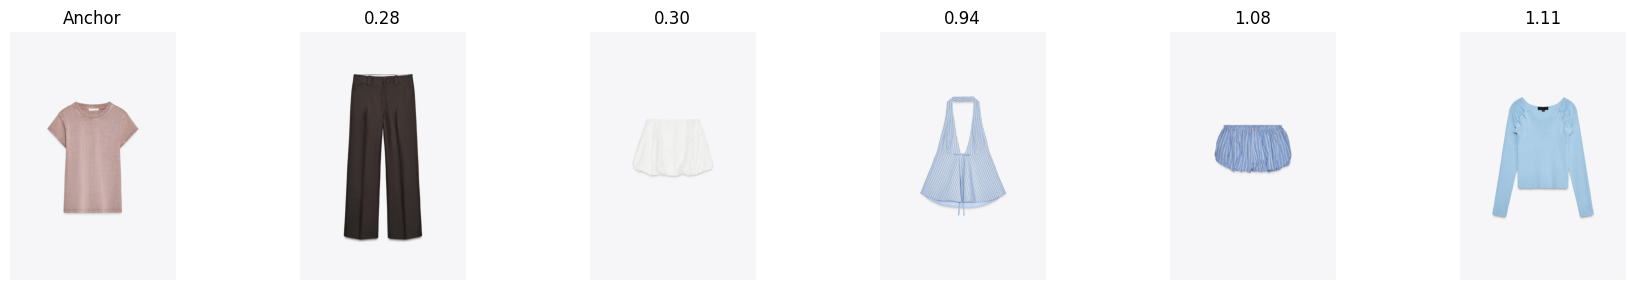

In [35]:
anchor = list(similar_items.keys())[51]  # or manually choose an anchor image name
show_similar_items_euclidean(anchor, similar_items[anchor], image_dir)


### Build the Recommender Dictionaries

In [36]:
top_k = 5  # Number of recommendations per item

cosine_recs = {}
euclidean_recs = {}

image_names = df["image"].tolist()  # Ensure same order as item_embeddings

for idx in range(num_item_nodes):
    anchor = image_names[idx]

    # ---- COSINE ----
    sim_scores = cos_sim_matrix[idx].clone()
    sim_scores[idx] = -1  # exclude self

    topk_cos_idx = torch.topk(sim_scores, top_k).indices
    cosine_recs[anchor] = [
        (image_names[i], round(sim_scores[i].item(), 4)) for i in topk_cos_idx
    ]

    # ---- EUCLIDEAN ----
    dist_scores = euclidean_matrix[idx].clone()
    dist_scores[idx] = float("inf")  # exclude self

    topk_euc_idx = torch.topk(-dist_scores, top_k).indices  # negative for lowest values
    euclidean_recs[anchor] = [
        (image_names[i], round(dist_scores[i].item(), 4)) for i in topk_euc_idx
    ]


In [37]:
cosine_recs["zara_05.jpg"]

[('zara_12.jpg', 1460.2423),
 ('zara_28.jpg', 1439.7328),
 ('zara_38.jpg', 1401.1973),
 ('zara_08.jpg', 1345.5101),
 ('zara_36.jpg', 1334.0771)]

In [40]:
import json

# Save cosine recommendations
with open(os.path.join(output_dir,"mvp_cosine_recs.json"), "w") as f:
    json.dump(cosine_recs, f, indent=2)

# Save euclidean recommendations
with open(os.path.join(output_dir,"mvp_euclidean_recs.json"), "w") as f:
    json.dump(euclidean_recs, f, indent=2)


In [41]:

def convert_to_df(rec_dict, mode="cosine"):
    rows = []
    for anchor, recs in rec_dict.items():
        for rec_img, score in recs:
            rows.append({"anchor": anchor, "recommended": rec_img, f"{mode}_score": score})
    return pd.DataFrame(rows)

# Convert to DataFrames
cosine_df = convert_to_df(cosine_recs, mode="cosine")
euclidean_df = convert_to_df(euclidean_recs, mode="euclidean")

# Save to CSV
cosine_df.to_csv(os.path.join(output_dir,"mvp_cosine_recs.csv"), index=False)
euclidean_df.to_csv(os.path.join(output_dir,"mvp_euclidean_recs.csv"), index=False)


In [42]:
cosine_df

anchor  recommended  cosine_score
0    zara_01.jpg  zara_12.jpg     1335.5179
1    zara_01.jpg  zara_28.jpg     1317.6293
2    zara_01.jpg  zara_38.jpg     1282.1473
3    zara_01.jpg  zara_08.jpg     1230.6049
4    zara_01.jpg  zara_36.jpg     1220.9371
..           ...          ...           ...
255  zara_53.jpg  zara_12.jpg     1907.2107
256  zara_53.jpg  zara_28.jpg     1881.2473
257  zara_53.jpg  zara_38.jpg     1830.6793
258  zara_53.jpg  zara_08.jpg     1757.3733
259  zara_53.jpg  zara_36.jpg     1743.1844

[260 rows x 3 columns]

### 🔁 Fusion Recommender

We combined cosine similarity (style-based) and inverse euclidean distance (category proximity) to build a fusion recommender:

`fusion_score = α * cosine + β * (1 / (1 + euclidean))`

Tested weights:
- 0.7 / 0.3 (style-dominant)
- 0.5 / 0.5 (balanced)

🧠 Result: Fusion gives more nuanced recommendations — blending visual style and category alignment. Ideal for guiding users toward stylistically relevant yet diverse options.



In [57]:
# alpha = weight for cosine, beta = weight for euclidean
alpha = 0.5
beta = 0.5

fusion_recs = {}

for idx in range(num_item_nodes):
    anchor = image_names[idx]

    sim_scores = cos_sim_matrix[idx].clone()
    sim_scores[idx] = -1  # Exclude self

    dist_scores = euclidean_matrix[idx].clone()
    dist_scores[idx] = float("inf")

    # Normalize both
    sim_norm = (sim_scores - sim_scores.min()) / (sim_scores.max() - sim_scores.min())
    dist_inv = 1 / (1 + dist_scores)
    dist_norm = (dist_inv - dist_inv.min()) / (dist_inv.max() - dist_inv.min())

    # Fusion score
    fusion_score = alpha * sim_norm + beta * dist_norm

    topk_fusion_idx = torch.topk(fusion_score, top_k).indices
    fusion_recs[anchor] = [
        (image_names[i], round(fusion_score[i].item(), 4)) for i in topk_fusion_idx
    ]


In [58]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def show_similar_items(anchor_img, top_k_list, image_dir):
    num_cols = len(top_k_list) + 1
    fig, axes = plt.subplots(1, num_cols, figsize=(3 * num_cols, 3))

    # Load and show anchor image
    anchor_path = os.path.join(image_dir, anchor_img)
    anchor_img_data = Image.open(anchor_path).convert("RGB")
    axes[0].imshow(anchor_img_data)
    axes[0].set_title("Anchor")
    axes[0].axis("off")

    # Show recommended images
    for i, (sim_img, score) in enumerate(top_k_list):
        img_path = os.path.join(image_dir, sim_img)
        img = Image.open(img_path).convert("RGB")
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"{score:.2f}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()


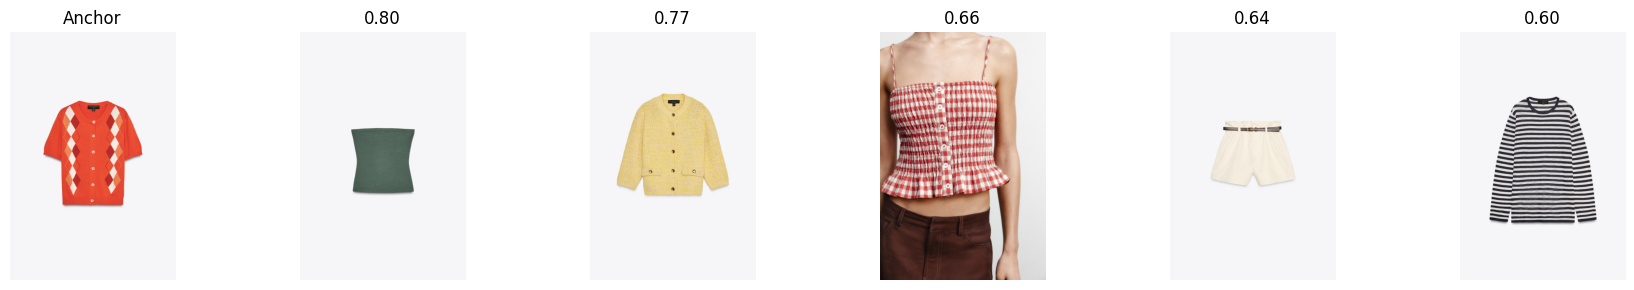

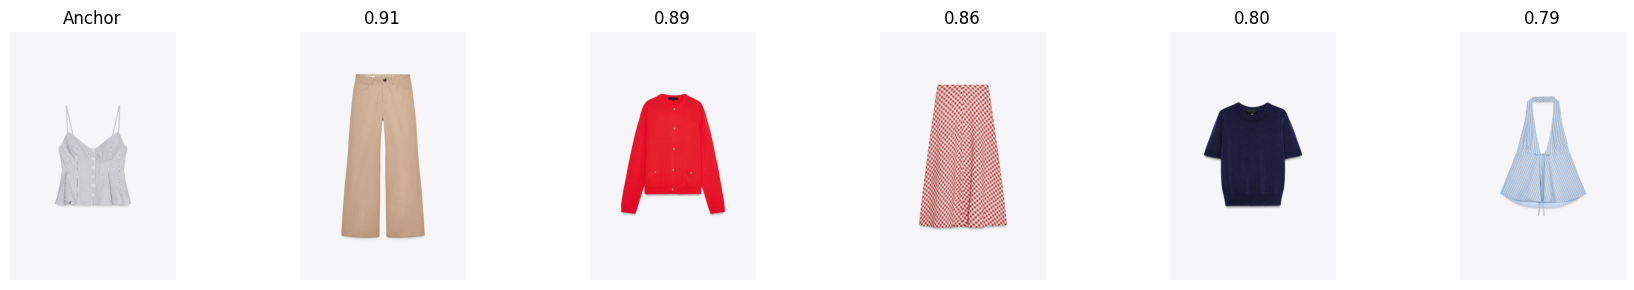

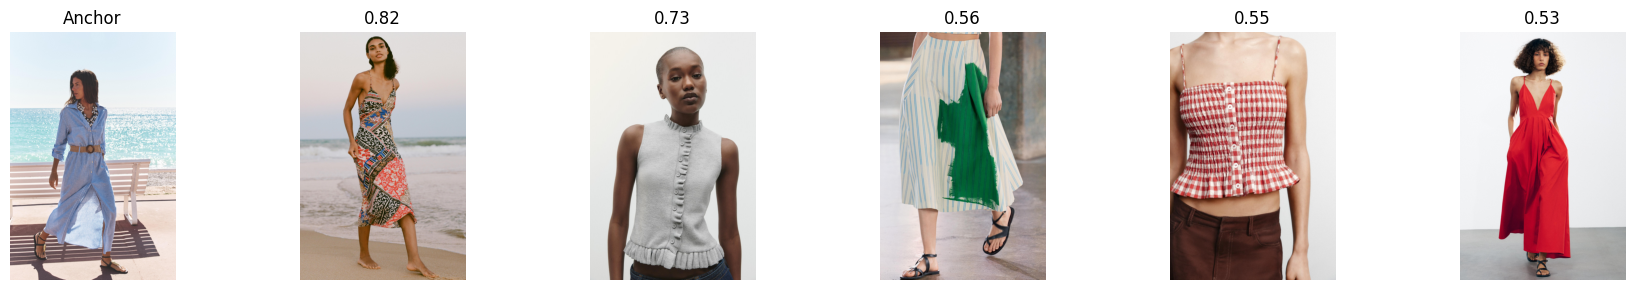

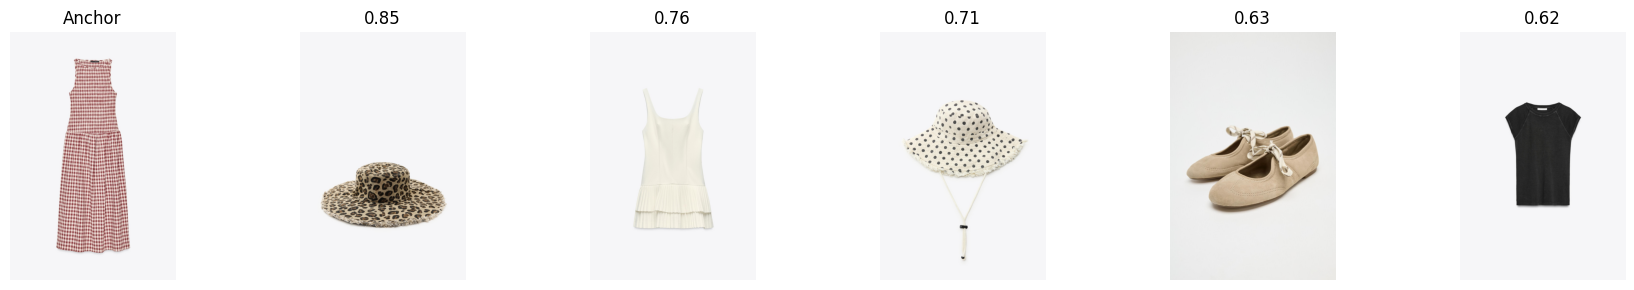

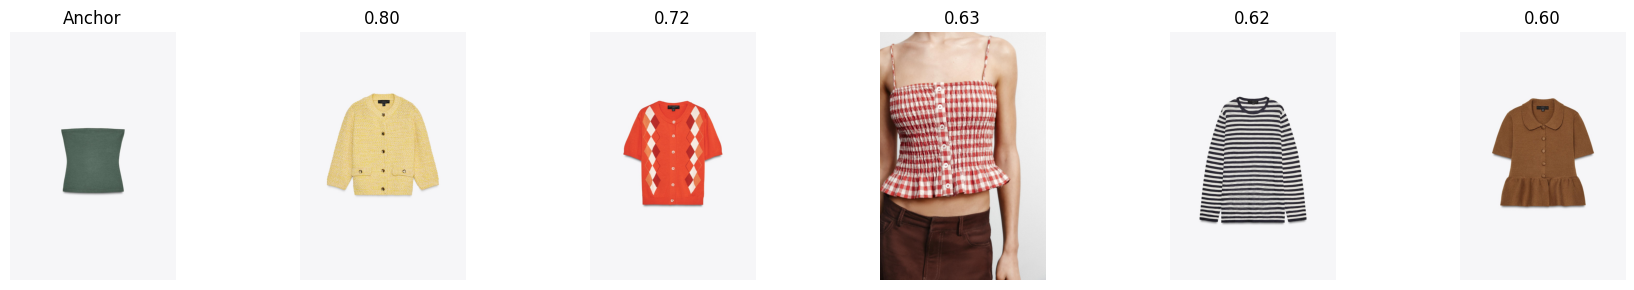

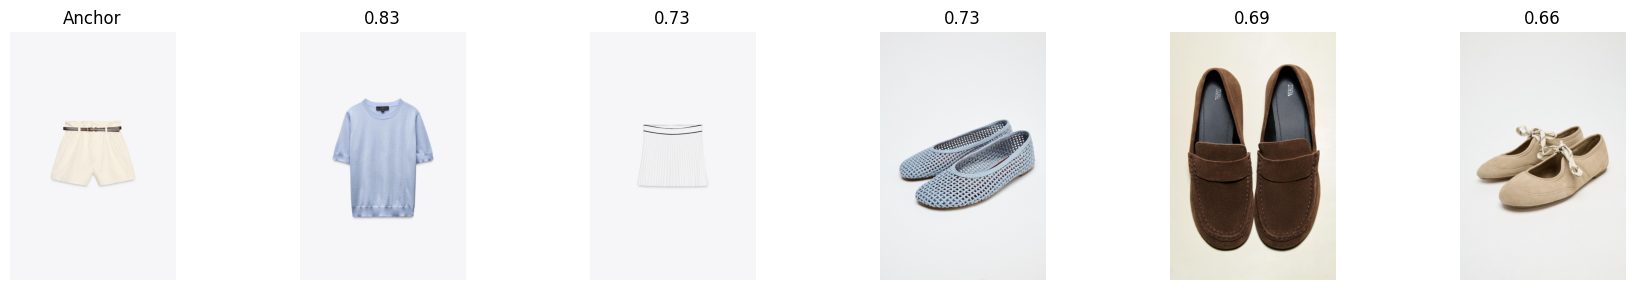

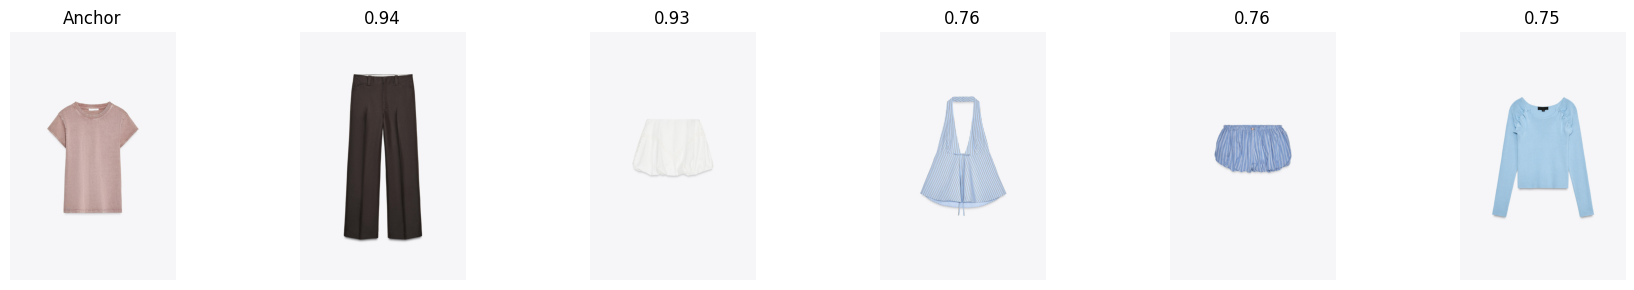

In [59]:
# 0.5, 0.5
disp_idx = [0, 15, 13, 24, 32, 43, 51]
for idx in disp_idx:
    anchor = image_names[idx]
    show_similar_items(anchor, fusion_recs[anchor], image_dir)

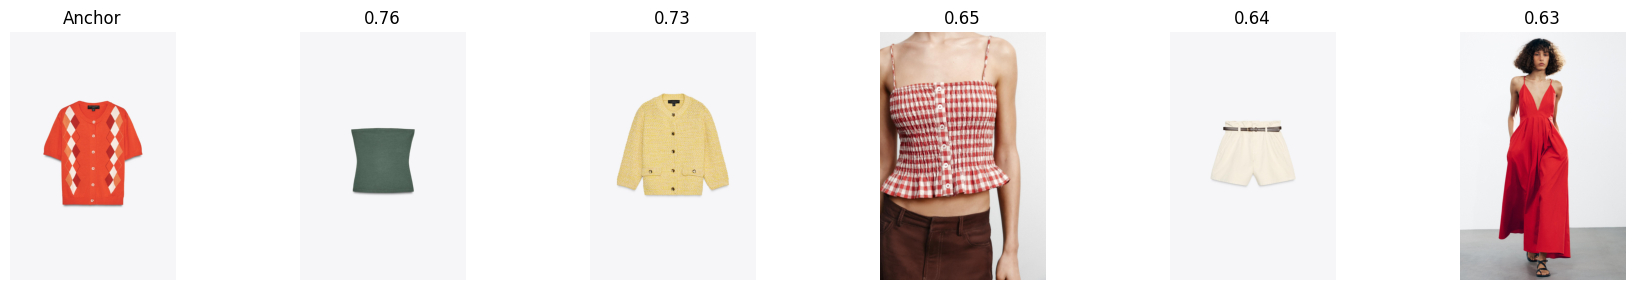

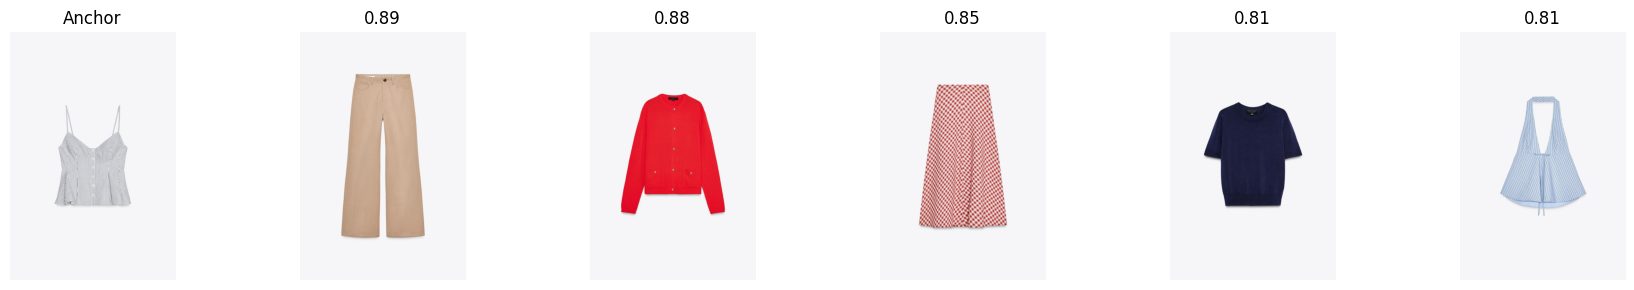

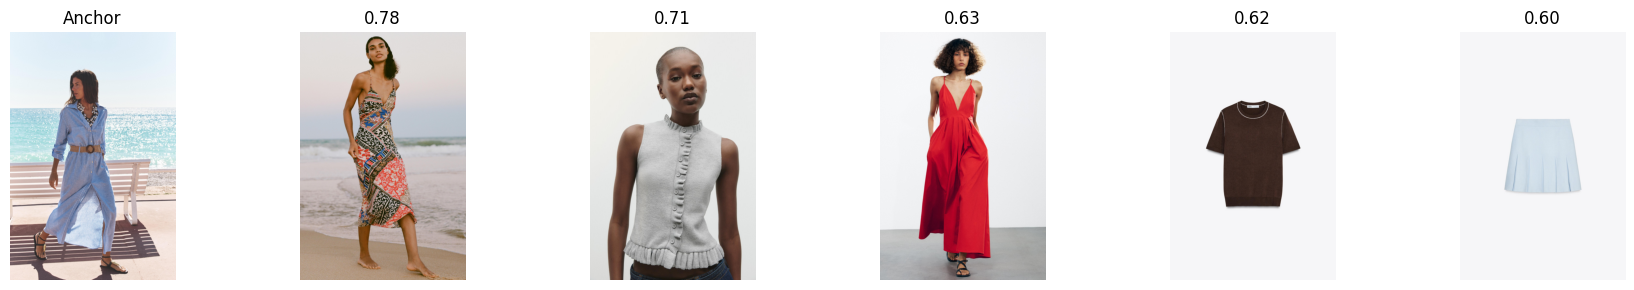

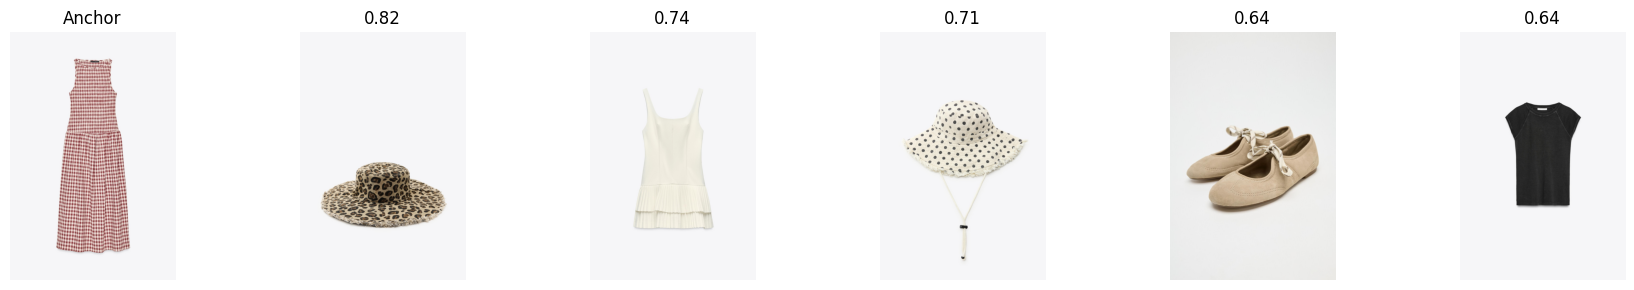

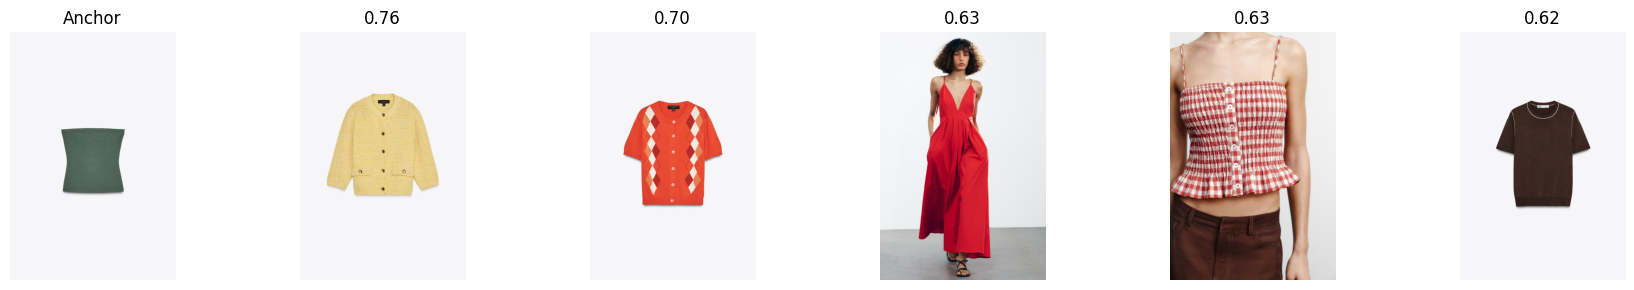

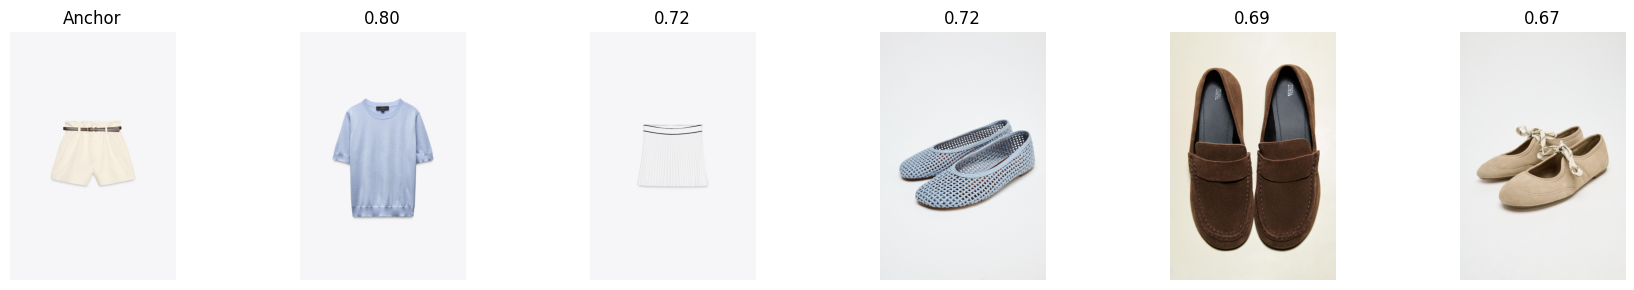

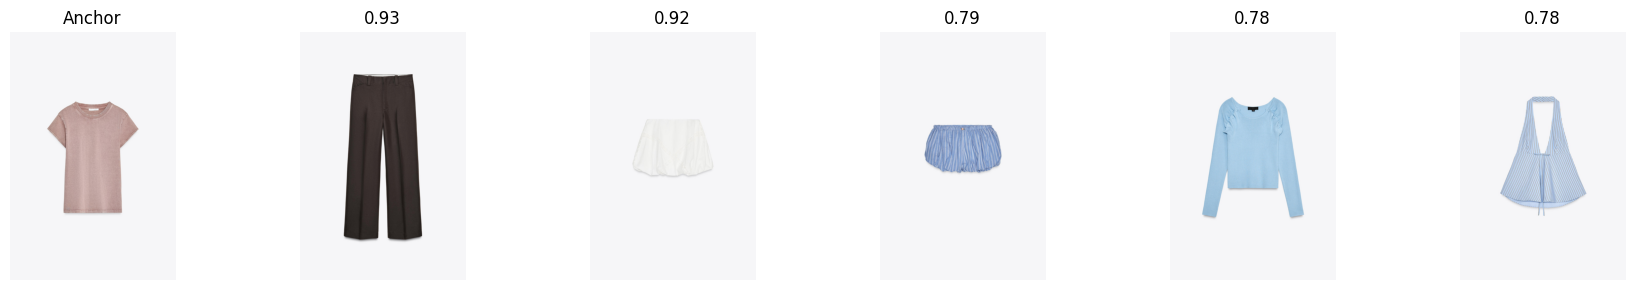

In [56]:
# 06., 0.4
disp_idx = [0, 15, 13, 24, 32, 43, 51]
for idx in disp_idx:
    anchor = image_names[idx]
    show_similar_items(anchor, fusion_recs[anchor], image_dir)

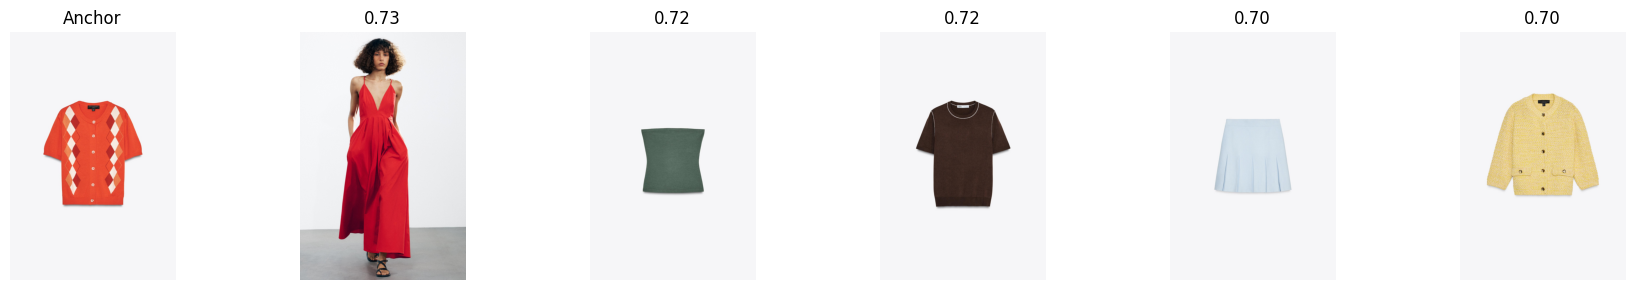

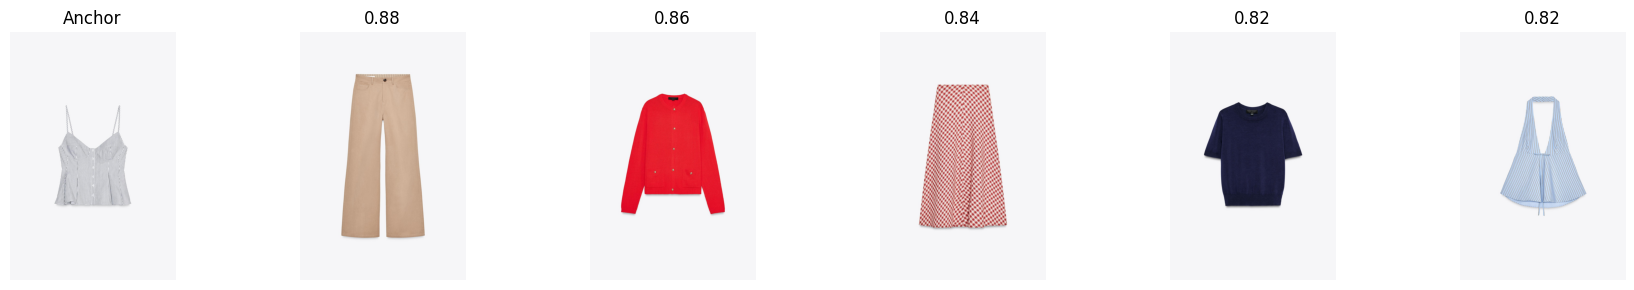

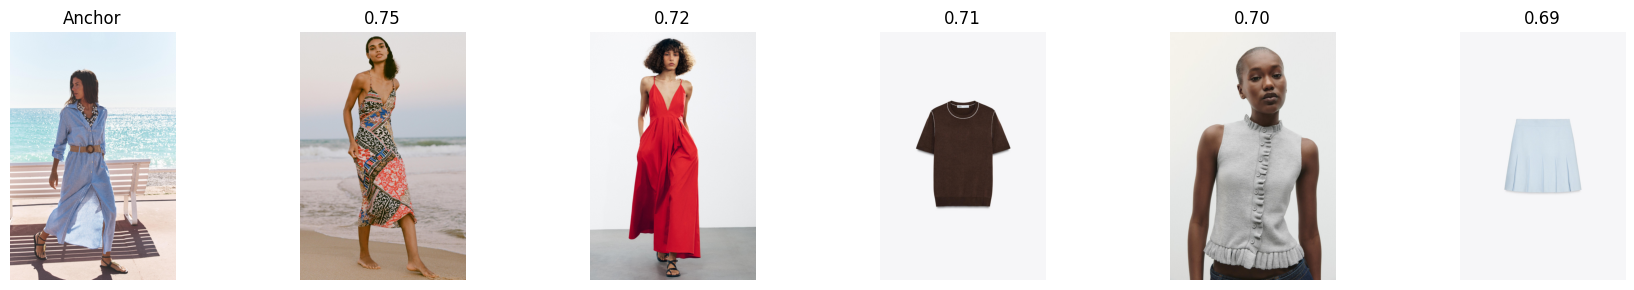

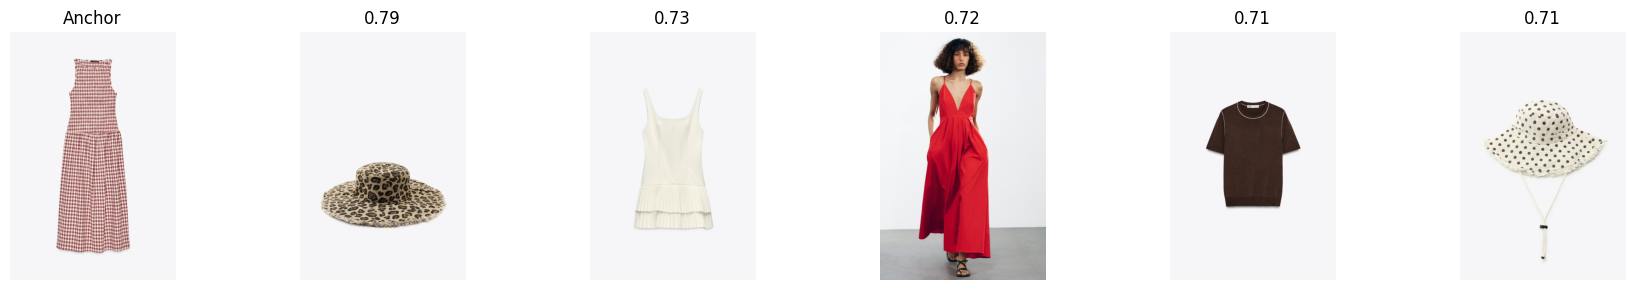

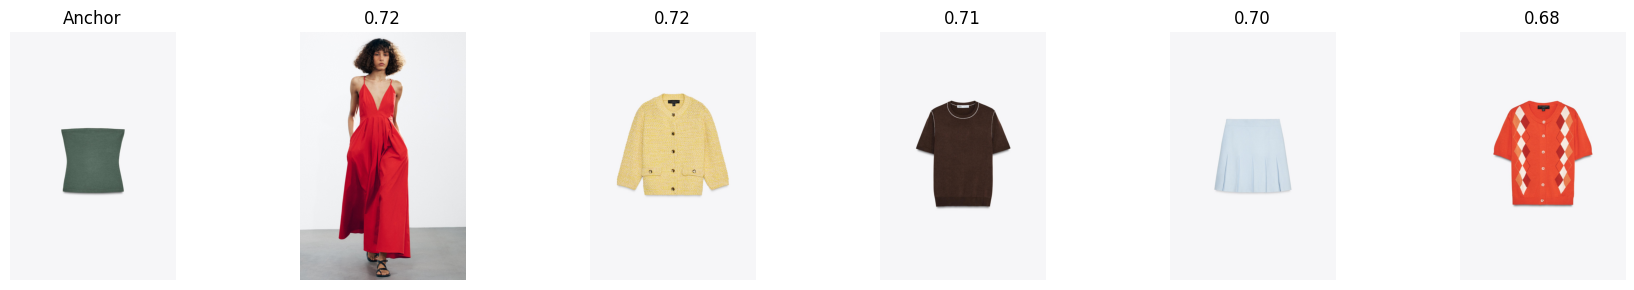

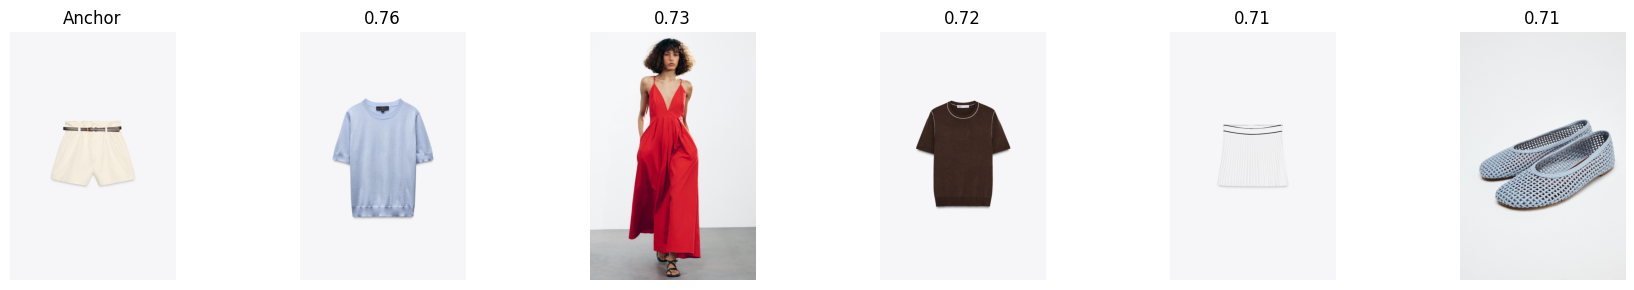

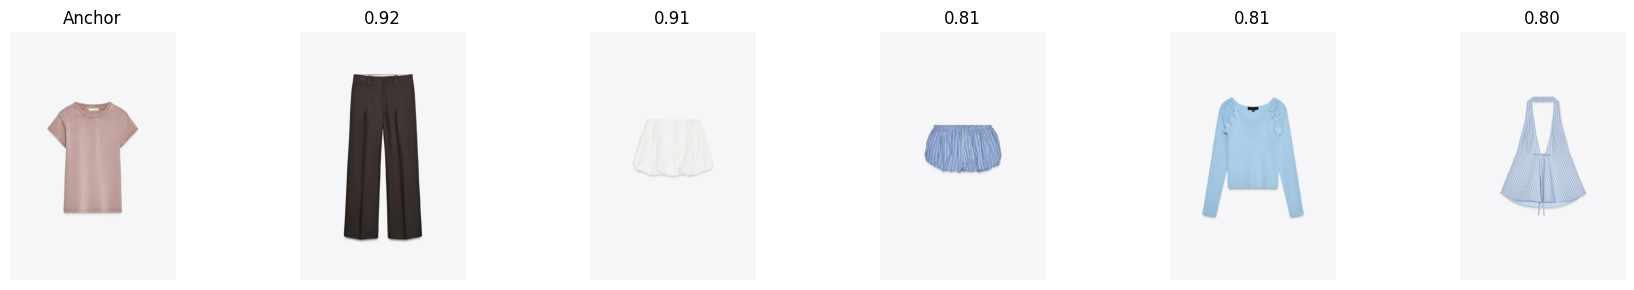

In [47]:
# 0.7, 0.3
disp_idx = [0, 15, 13, 24, 32, 43, 51]
for idx in disp_idx:
    anchor = image_names[idx]
    show_similar_items(anchor, fusion_recs[anchor], image_dir)


### App simulation ☄️

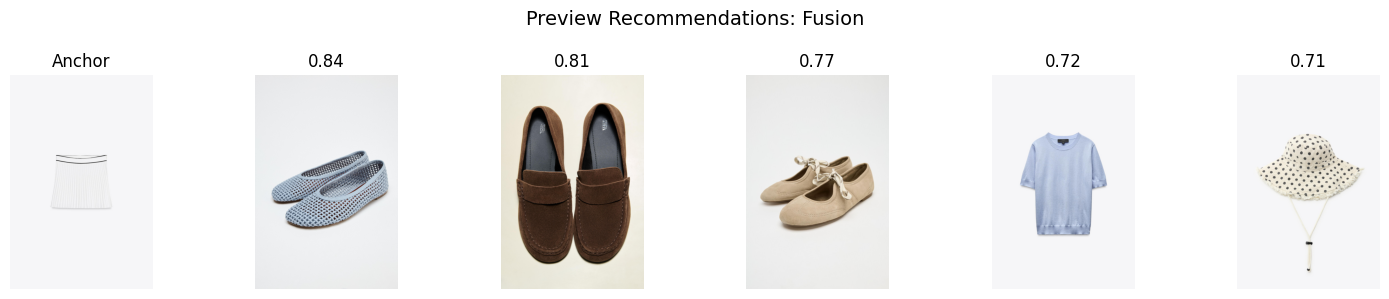

In [62]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# Pick a recommendation mode
mode = "Fusion"  # change to "Cosine", "Euclidean", or "Fusion"

# Pick an anchor item to visualize
anchor = list(cosine_recs.keys())[4]  # try "zara_05.jpg" or similar

# Get recs based on mode
if mode == "Cosine":
    recs = cosine_recs[anchor]
elif mode == "Euclidean":
    recs = euclidean_recs[anchor]
else:
    recs = fusion_recs[anchor]

# Show anchor + top recs
def preview_recs(anchor_img, recs, image_dir, title="Preview Recommendations"):
    fig, axs = plt.subplots(1, len(recs) + 1, figsize=(15, 3))
    axs[0].imshow(Image.open(Path(image_dir) / anchor_img))
    axs[0].axis('off')
    axs[0].set_title("Anchor")

    for i, (img_name, score) in enumerate(recs):
        img_item = os.path.join(image_dir, img_name)
        img = Image.open(Path(img_item))
        axs[i + 1].imshow(img)
        axs[i + 1].axis('off')
        axs[i + 1].set_title(f"{score:.2f}")

    plt.suptitle(f"{title}: {mode}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Run preview
preview_recs(anchor, recs, image_dir=image_dir)
